In [288]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import torch
import shutil 
from tqdm import tqdm
import os
import torchvision
import matplotlib.pyplot as plt
import seaborn as sns
import time
import copy
import random
import subprocess
import zipfile

from torchvision import transforms, models

seed = 7
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

In [289]:
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

with zipfile.ZipFile('../input/platesv2/plates.zip', 'r') as zip_obj:
   # Extract all the contents of zip file in current directory
   zip_obj.extractall('/kaggle/working/')
    
print('After zip extraction:')
print(os.listdir("/kaggle/working/"))

['platesv2']
After zip extraction:
['val', '__MACOSX', 'train', 'submission.csv', '.virtual_documents', 'plates', '__notebook_source__.ipynb']


In [290]:
data_root = '/kaggle/working/plates/'
print(os.listdir(data_root))

['test', 'train', '.DS_Store']


In [291]:
train_dir = 'train'
val_dir = 'val'

class_names = ['cleaned', 'dirty']

for dir_name in [train_dir, val_dir]:
    for class_name in class_names:
        os.makedirs(os.path.join(dir_name, class_name), exist_ok=True)

for class_name in class_names:
    source_dir = os.path.join(data_root, 'train', class_name)
    for i, file_name in enumerate(tqdm(os.listdir(source_dir))):
        if i % 6 != 0:
            dest_dir = os.path.join(train_dir, class_name) 
        else:
            dest_dir = os.path.join(val_dir, class_name)
        shutil.copy(os.path.join(source_dir, file_name), os.path.join(dest_dir, file_name))

100%|██████████| 21/21 [00:00<00:00, 2432.15it/s]


In [292]:
train_transforms = transforms.Compose([
    transforms.CenterCrop(200),
    transforms.ColorJitter(brightness=0.2, contrast=0.4, saturation=0.4, hue=0.4),
    transforms.RandomOrder([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
        ]),

    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.CenterCrop(150),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_dataset = torchvision.datasets.ImageFolder(train_dir, train_transforms)
val_dataset = torchvision.datasets.ImageFolder(val_dir, val_transforms)

batch_size = 8
train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=batch_size)
val_dataloader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False, num_workers=batch_size)

In [293]:
len(train_dataloader), len(train_dataset)

(4, 32)

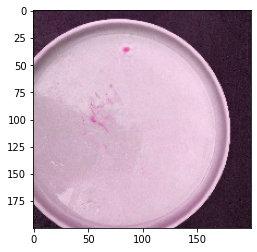

In [294]:
X_batch, y_batch = next(iter(train_dataloader))
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
plt.imshow(X_batch[0].permute(1, 2, 0).numpy() * std + mean);

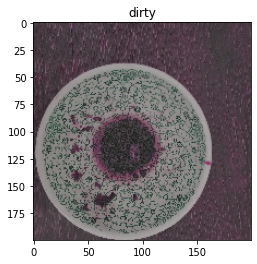

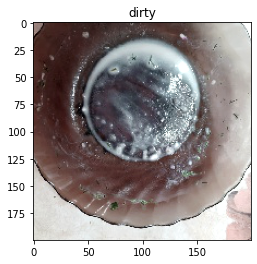

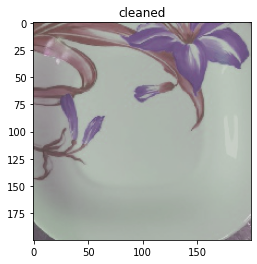

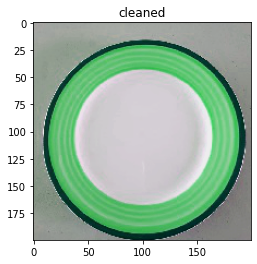

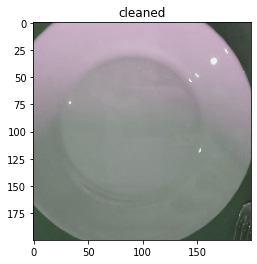

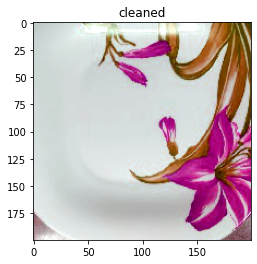

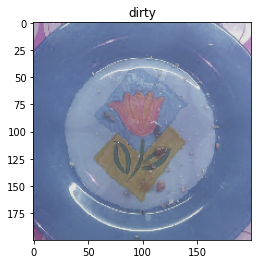

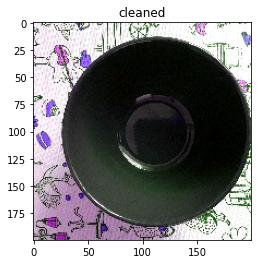

In [295]:
def show_input(input_tensor, title=''):
    image = input_tensor.permute(1, 2, 0).numpy()
    image = std * image + mean
    plt.imshow(image.clip(0, 1))
    plt.title(title)
    plt.show()
    plt.pause(0.001)

X_batch, y_batch = next(iter(train_dataloader))

for x_item, y_item in zip(X_batch, y_batch):
    show_input(x_item, title=class_names[y_item])

In [296]:
def train_model(model, loss, optimizer, scheduler, num_epochs):
    for epoch in range(num_epochs):
        print('Epoch {}/{}:'.format(epoch, num_epochs - 1), flush=True)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                dataloader = train_dataloader
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                dataloader = val_dataloader
                model.eval()   # Set model to evaluate mode

            running_loss = 0.
            running_acc = 0.

            # Iterate over data.
            for inputs, labels in tqdm(dataloader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                # forward and backward
                with torch.set_grad_enabled(phase == 'train'):
                    preds = model(inputs)
                    loss_value = loss(preds, labels)
                    preds_class = preds.argmax(dim=1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss_value.backward()
                        optimizer.step()

                # statistics
                running_loss += loss_value.item()
                running_acc += (preds_class == labels.data).float().mean()

            epoch_loss = running_loss / len(dataloader)
            epoch_acc = running_acc / len(dataloader)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc), flush=True)

    return model

In [297]:
model = models.resnet18(pretrained=True)


In [331]:

# Disable grad for all conv layers
for param in model.parameters():
    param.requires_grad = False

model.fc = torch.nn.Linear(model.fc.in_features, 2)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

loss = torch.nn.CrossEntropyLoss()
#optimizer = torch.optim.Adam(model.parameters(), lr=1.0e-3)
optimizer = torch.optim.SGD(model.parameters(), lr=0.0313)

# Decay LR by a factor of 0.1 every 7 epochs
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=8, gamma=0.1)

In [332]:
train_model(model, loss, optimizer, scheduler, num_epochs=50);


Epoch 0/49:


/opt/conda/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
  0%|          | 0/4 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slown

train Loss: 3.0240 Acc: 0.4688



100%|██████████| 1/1 [00:00<00:00,  1.94it/s]

val Loss: 4.5367 Acc: 0.5000
Epoch 1/49:



100%|██████████| 4/4 [00:00<00:00,  5.43it/s]


train Loss: 5.7738 Acc: 0.3125


100%|██████████| 1/1 [00:00<00:00,  1.76it/s]

val Loss: 5.2413 Acc: 0.5000
Epoch 2/49:



100%|██████████| 4/4 [00:00<00:00,  5.28it/s]

train Loss: 1.6641 Acc: 0.6562



100%|██████████| 1/1 [00:00<00:00,  1.85it/s]

val Loss: 3.2054 Acc: 0.5000
Epoch 3/49:



100%|██████████| 4/4 [00:00<00:00,  5.37it/s]

train Loss: 2.0651 Acc: 0.5938



100%|██████████| 1/1 [00:00<00:00,  1.72it/s]

val Loss: 2.2060 Acc: 0.5000
Epoch 4/49:



100%|██████████| 4/4 [00:01<00:00,  3.50it/s]

train Loss: 3.4123 Acc: 0.5000



100%|██████████| 1/1 [00:00<00:00,  1.54it/s]

val Loss: 0.9588 Acc: 0.6250
Epoch 5/49:



100%|██████████| 4/4 [00:00<00:00,  5.39it/s]

train Loss: 0.7559 Acc: 0.6250



100%|██████████| 1/1 [00:00<00:00,  1.84it/s]

val Loss: 4.2370 Acc: 0.5000
Epoch 6/49:



100%|██████████| 4/4 [00:00<00:00,  5.36it/s]

train Loss: 1.4122 Acc: 0.5625



100%|██████████| 1/1 [00:00<00:00,  1.94it/s]

val Loss: 4.3296 Acc: 0.5000
Epoch 7/49:



100%|██████████| 4/4 [00:00<00:00,  4.21it/s]

train Loss: 2.4979 Acc: 0.5312



100%|██████████| 1/1 [00:00<00:00,  1.70it/s]

val Loss: 2.0115 Acc: 0.5000
Epoch 8/49:



100%|██████████| 4/4 [00:00<00:00,  5.30it/s]

train Loss: 0.6129 Acc: 0.7188



100%|██████████| 1/1 [00:00<00:00,  1.83it/s]

val Loss: 0.9529 Acc: 0.7500


Epoch 9/49:


100%|██████████| 4/4 [00:00<00:00,  5.36it/s]

train Loss: 0.2302 Acc: 0.9062



100%|██████████| 1/1 [00:00<00:00,  1.86it/s]

val Loss: 0.7473 Acc: 0.7500
Epoch 10/49:



100%|██████████| 4/4 [00:00<00:00,  5.45it/s]

train Loss: 0.1295 Acc: 0.9688



100%|██████████| 1/1 [00:00<00:00,  1.85it/s]


val Loss: 0.7310 Acc: 0.7500
Epoch 11/49:


100%|██████████| 4/4 [00:00<00:00,  5.41it/s]

train Loss: 0.1132 Acc: 1.0000



100%|██████████| 1/1 [00:00<00:00,  1.89it/s]

val Loss: 0.7162 Acc: 0.7500
Epoch 12/49:



100%|██████████| 4/4 [00:00<00:00,  5.36it/s]

train Loss: 0.1656 Acc: 0.9062



100%|██████████| 1/1 [00:00<00:00,  1.86it/s]

val Loss: 0.7052 Acc: 0.7500
Epoch 13/49:



100%|██████████| 4/4 [00:00<00:00,  5.24it/s]

train Loss: 0.4242 Acc: 0.7812



100%|██████████| 1/1 [00:00<00:00,  1.92it/s]

val Loss: 0.7062 Acc: 0.7500
Epoch 14/49:



100%|██████████| 4/4 [00:00<00:00,  5.27it/s]

train Loss: 0.1688 Acc: 0.9375



100%|██████████| 1/1 [00:00<00:00,  1.63it/s]

val Loss: 0.7283 Acc: 0.7500
Epoch 15/49:



100%|██████████| 4/4 [00:00<00:00,  4.33it/s]

train Loss: 0.1165 Acc: 0.9688



100%|██████████| 1/1 [00:00<00:00,  1.57it/s]

val Loss: 0.7439 Acc: 0.6250
Epoch 16/49:



100%|██████████| 4/4 [00:00<00:00,  5.56it/s]

train Loss: 0.1600 Acc: 0.9375



100%|██████████| 1/1 [00:00<00:00,  1.88it/s]

val Loss: 0.6738 Acc: 0.7500
Epoch 17/49:



100%|██████████| 4/4 [00:00<00:00,  5.49it/s]

train Loss: 0.1711 Acc: 0.9062



100%|██████████| 1/1 [00:00<00:00,  1.84it/s]

val Loss: 0.6618 Acc: 0.7500
Epoch 18/49:



100%|██████████| 4/4 [00:00<00:00,  5.18it/s]

train Loss: 0.1131 Acc: 0.9688



100%|██████████| 1/1 [00:00<00:00,  1.86it/s]


val Loss: 0.6491 Acc: 0.7500
Epoch 19/49:


100%|██████████| 4/4 [00:00<00:00,  5.45it/s]

train Loss: 0.1658 Acc: 0.9375



100%|██████████| 1/1 [00:00<00:00,  1.80it/s]

val Loss: 0.6415 Acc: 0.7500
Epoch 20/49:



100%|██████████| 4/4 [00:00<00:00,  5.48it/s]

train Loss: 0.2435 Acc: 0.8750



100%|██████████| 1/1 [00:00<00:00,  1.87it/s]

val Loss: 0.6702 Acc: 0.7500
Epoch 21/49:



100%|██████████| 4/4 [00:00<00:00,  5.42it/s]

train Loss: 0.0586 Acc: 1.0000



100%|██████████| 1/1 [00:00<00:00,  1.80it/s]

val Loss: 0.6854 Acc: 0.7500
Epoch 22/49:



100%|██████████| 4/4 [00:00<00:00,  5.29it/s]

train Loss: 0.5946 Acc: 0.7812



100%|██████████| 1/1 [00:00<00:00,  1.84it/s]

val Loss: 0.7299 Acc: 0.7500
Epoch 23/49:



100%|██████████| 4/4 [00:00<00:00,  4.61it/s]

train Loss: 0.2042 Acc: 0.9375



100%|██████████| 1/1 [00:00<00:00,  1.53it/s]

val Loss: 0.7461 Acc: 0.7500
Epoch 24/49:



100%|██████████| 4/4 [00:00<00:00,  5.28it/s]

train Loss: 0.1414 Acc: 0.9688



100%|██████████| 1/1 [00:00<00:00,  1.88it/s]


val Loss: 0.7676 Acc: 0.7500
Epoch 25/49:


100%|██████████| 4/4 [00:00<00:00,  5.31it/s]

train Loss: 0.1939 Acc: 0.9062



100%|██████████| 1/1 [00:00<00:00,  1.86it/s]

val Loss: 0.7118 Acc: 0.7500
Epoch 26/49:



100%|██████████| 4/4 [00:00<00:00,  5.39it/s]

train Loss: 0.2163 Acc: 0.9062



100%|██████████| 1/1 [00:00<00:00,  1.88it/s]

val Loss: 0.7255 Acc: 0.7500
Epoch 27/49:



100%|██████████| 4/4 [00:00<00:00,  4.58it/s]

train Loss: 0.0746 Acc: 0.9688



100%|██████████| 1/1 [00:00<00:00,  1.10it/s]

val Loss: 0.7050 Acc: 0.7500
Epoch 28/49:



100%|██████████| 4/4 [00:00<00:00,  5.03it/s]

train Loss: 0.0983 Acc: 0.9688



100%|██████████| 1/1 [00:00<00:00,  1.86it/s]


val Loss: 0.7784 Acc: 0.7500
Epoch 29/49:


100%|██████████| 4/4 [00:00<00:00,  5.38it/s]

train Loss: 0.0948 Acc: 1.0000



100%|██████████| 1/1 [00:00<00:00,  1.85it/s]

val Loss: 0.7891 Acc: 0.6250
Epoch 30/49:



100%|██████████| 4/4 [00:00<00:00,  5.34it/s]

train Loss: 0.2456 Acc: 0.8750



100%|██████████| 1/1 [00:00<00:00,  1.84it/s]

val Loss: 0.7768 Acc: 0.6250
Epoch 31/49:



100%|██████████| 4/4 [00:00<00:00,  4.22it/s]

train Loss: 0.1583 Acc: 0.9375



100%|██████████| 1/1 [00:00<00:00,  1.61it/s]

val Loss: 0.7551 Acc: 0.6250
Epoch 32/49:



100%|██████████| 4/4 [00:00<00:00,  5.14it/s]

train Loss: 0.1236 Acc: 0.9688



100%|██████████| 1/1 [00:00<00:00,  1.87it/s]

val Loss: 0.7148 Acc: 0.7500
Epoch 33/49:



100%|██████████| 4/4 [00:00<00:00,  5.08it/s]

train Loss: 0.2170 Acc: 0.8750



100%|██████████| 1/1 [00:00<00:00,  1.79it/s]

val Loss: 0.7330 Acc: 0.7500
Epoch 34/49:



100%|██████████| 4/4 [00:00<00:00,  5.22it/s]

train Loss: 0.1901 Acc: 0.8750



100%|██████████| 1/1 [00:00<00:00,  1.77it/s]

val Loss: 0.7165 Acc: 0.7500
Epoch 35/49:



100%|██████████| 4/4 [00:00<00:00,  5.37it/s]

train Loss: 0.1621 Acc: 0.9688



100%|██████████| 1/1 [00:00<00:00,  1.81it/s]

val Loss: 0.7846 Acc: 0.7500
Epoch 36/49:



100%|██████████| 4/4 [00:00<00:00,  5.53it/s]

train Loss: 0.1967 Acc: 0.9062



100%|██████████| 1/1 [00:00<00:00,  1.84it/s]


val Loss: 0.7871 Acc: 0.7500
Epoch 37/49:


100%|██████████| 4/4 [00:00<00:00,  5.32it/s]

train Loss: 0.3107 Acc: 0.8750



100%|██████████| 1/1 [00:00<00:00,  1.82it/s]

val Loss: 0.7270 Acc: 0.7500
Epoch 38/49:



100%|██████████| 4/4 [00:00<00:00,  5.37it/s]

train Loss: 0.2182 Acc: 0.8750



100%|██████████| 1/1 [00:00<00:00,  1.85it/s]


val Loss: 0.6956 Acc: 0.7500
Epoch 39/49:


100%|██████████| 4/4 [00:00<00:00,  4.34it/s]

train Loss: 0.0677 Acc: 1.0000



100%|██████████| 1/1 [00:00<00:00,  1.57it/s]


val Loss: 0.6873 Acc: 0.7500
Epoch 40/49:


100%|██████████| 4/4 [00:00<00:00,  5.35it/s]


train Loss: 0.0935 Acc: 1.0000


100%|██████████| 1/1 [00:00<00:00,  1.89it/s]


val Loss: 0.6935 Acc: 0.6250
Epoch 41/49:


100%|██████████| 4/4 [00:00<00:00,  5.49it/s]

train Loss: 0.1420 Acc: 0.9375



100%|██████████| 1/1 [00:00<00:00,  1.83it/s]

val Loss: 0.7134 Acc: 0.6250
Epoch 42/49:



100%|██████████| 4/4 [00:00<00:00,  5.54it/s]

train Loss: 0.1889 Acc: 0.8750



100%|██████████| 1/1 [00:00<00:00,  1.85it/s]

val Loss: 0.7029 Acc: 0.6250
Epoch 43/49:



100%|██████████| 4/4 [00:00<00:00,  5.43it/s]

train Loss: 0.0669 Acc: 1.0000



100%|██████████| 1/1 [00:00<00:00,  1.91it/s]


val Loss: 0.7005 Acc: 0.7500
Epoch 44/49:


100%|██████████| 4/4 [00:00<00:00,  5.43it/s]

train Loss: 0.2543 Acc: 0.9375



100%|██████████| 1/1 [00:00<00:00,  1.84it/s]

val Loss: 0.7087 Acc: 0.6250
Epoch 45/49:



100%|██████████| 4/4 [00:00<00:00,  5.50it/s]

train Loss: 0.1939 Acc: 0.9062



100%|██████████| 1/1 [00:00<00:00,  1.89it/s]

val Loss: 0.7052 Acc: 0.6250
Epoch 46/49:



100%|██████████| 4/4 [00:00<00:00,  5.24it/s]

train Loss: 0.3042 Acc: 0.8438



100%|██████████| 1/1 [00:00<00:00,  1.75it/s]

val Loss: 0.6868 Acc: 0.6250
Epoch 47/49:



100%|██████████| 4/4 [00:00<00:00,  4.48it/s]

train Loss: 0.3221 Acc: 0.8438



100%|██████████| 1/1 [00:00<00:00,  1.51it/s]

val Loss: 0.7192 Acc: 0.7500
Epoch 48/49:



100%|██████████| 4/4 [00:00<00:00,  5.42it/s]

train Loss: 0.1923 Acc: 0.8750



100%|██████████| 1/1 [00:00<00:00,  1.87it/s]


val Loss: 0.6854 Acc: 0.6250
Epoch 49/49:


100%|██████████| 4/4 [00:00<00:00,  5.38it/s]

train Loss: 0.1577 Acc: 0.9062



100%|██████████| 1/1 [00:00<00:00,  1.86it/s]

val Loss: 0.7165 Acc: 0.7500


In [333]:
test_dir = 'test'
shutil.copytree(os.path.join(data_root, 'test'), os.path.join(test_dir, 'unknown'))

FileExistsError: [Errno 17] File exists: 'test/unknown'

In [334]:
class ImageFolderWithPaths(torchvision.datasets.ImageFolder):
    def __getitem__(self, index):
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        path = self.imgs[index][0]
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path
    
test_dataset = ImageFolderWithPaths('/kaggle/working/test', val_transforms)

test_dataloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

In [335]:
test_dataset


Dataset ImageFolderWithPaths
    Number of datapoints: 744
    Root location: /kaggle/working/test
    StandardTransform
Transform: Compose(
               CenterCrop(size=(150, 150))
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [336]:
model.eval()

test_predictions = []
test_img_paths = []
for inputs, labels, paths in tqdm(test_dataloader):
    inputs = inputs.to(device)
    labels = labels.to(device)
    with torch.set_grad_enabled(False):
        preds = model(inputs)
    test_predictions.append(
        torch.nn.functional.softmax(preds, dim=1)[:,1].data.cpu().numpy())
    test_img_paths.extend(paths)
    
test_predictions = np.concatenate(test_predictions)

100%|██████████| 93/93 [00:06<00:00, 14.61it/s]


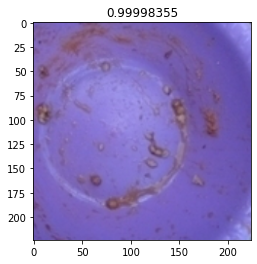

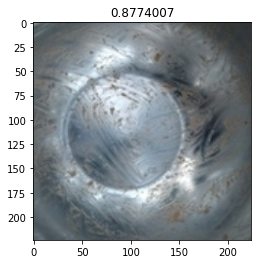

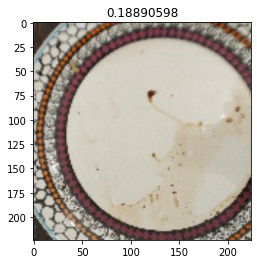

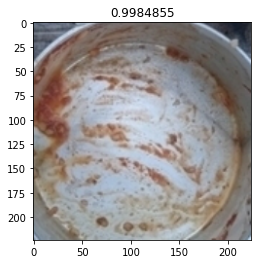

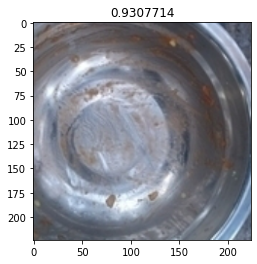

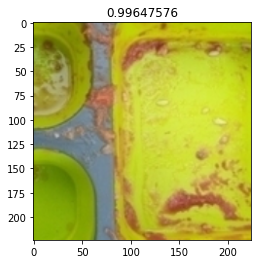

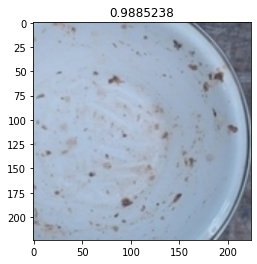

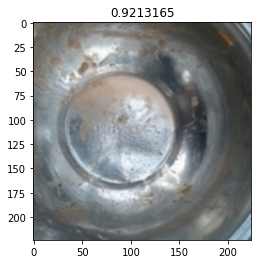

In [337]:
inputs, labels, paths = next(iter(test_dataloader))

for img, pred in zip(inputs, test_predictions):
    show_input(img, title=pred)

In [362]:
submission_df = pd.DataFrame.from_dict({'id': test_img_paths, 'label': test_predictions})


In [363]:
submission_df['label'] = submission_df['label'].map(lambda pred: 'dirty' if pred > 0.8091282 else 'cleaned')
submission_df['id'] = submission_df['id'].str.replace('/kaggle/working/test/unknown/', '')
submission_df['id'] = submission_df['id'].str.replace('.jpg', '')
submission_df.set_index('id', inplace=True)
submission_df.head(n=6)


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  This is separate from the ipykernel package so we can avoid doing imports until


,label
id,
0000,dirty
0001,dirty
0002,cleaned
0003,dirty
0004,dirty
0005,dirty


In [364]:
submission_df.to_csv('submission.csv')


In [267]:
!rm -rf train val test
